# Intro

The purpose of this code is to look at relationships between stock data and the sentiment scores of articles regarding said stocks. We will use sentiment scores generated by VADER and FinVADER. The stocks are sorted by data+ticker, or date+sector (Tech, Health, Finance). The naive mean is taken between the sentiment scores of all articles on a particular stock in the same day. 

The goal is to provide plots of these sentiment scores against the closing stock prices up to a week afer said score. 

# Packages


In [1]:
!pip install finvader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from finvader import finvader as fv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sultanitw/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here I mess around with the csv files to look for possible inconsistencies. I also test out FinVADER compound sentiment scores versus those from regular VADER

In [90]:
df = pd.read_csv('../data/news_data_2019_2024_complete.csv')
df2 = pd.read_csv('../data/data_merged.csv')
print(df2[df2['Ticker']=='AAPL'].iloc[0])
print(df[df['Ticker']=='AAPL'].iloc[0])
apple = pd.read_csv('../Stock_data/Apple_stock.csv')
apple.iloc[10]
txt= df['Headline'].iloc[0] +' '+ df['Text'].iloc[0]
print(txt)
print(fv(text = txt, use_henry= True, use_sentibignomics=True, indicator='compound'))
print(fv(text = txt, use_henry= True, use_sentibignomics=False, indicator='compound'))
#  fv(text = txt, use_henry= False, use_sentibignomics=False, indicator='compound')
print(fv(text = txt, use_henry= False, use_sentibignomics=True, indicator='compound'))
analyzer = SentimentIntensityAnalyzer()
print(analyzer.polarity_scores(txt))


Unnamed: 0              1364
Date              2019-03-15
Ticker                  AAPL
Sector            Technology
sentiment_neg            0.0
sentiment_neu            0.0
sentiment_pos            0.0
sentiment_tot            0.0
Open                  44.428
High                  45.025
Low                   44.162
Close                 44.734
Volume           156171600.0
Name: 1364, dtype: object
Unnamed: 0                                                       1
Date & Time                              2019-03-15 10:47:26+00:00
Date                                                    2019-03-15
Time                                                      10:47:26
Ticker                                                        AAPL
Sector                                                  Technology
Source                                             The Motley Fool
sentiment_neg                                                  0.0
sentiment_neu                                                

# DataFrames

Now we want to create the necesssary dataframes that we will be working with

First, we need to incorporate the FinVader sentiment scores of our articles. The following function does this for us, which we then apply to our dataframe to create a new column for FinVader scores.

In [91]:
def fin_sentiment_score(headline:str, abstract:str):
    txt = headline + ' ' + abstract
    return fv(text = txt, use_henry= True, use_sentibignomics=True, indicator='compound')


In [92]:
#The resulting dataframe is now contained in the csv file data_finvader.csv. It is better to just read from there, as this takes 5-6 minutes to complie
df['finvader'] = df.apply(lambda x: fin_sentiment_score(x['Headline'], x['Text']), axis = 1)


Now we group our sentiment scores by date+ticker and date+sector. The following dataframes are created by taking the naive mean on these groups. 

In [102]:
df.drop(labels = ['Unnamed: 0', 'Date & Time', 'sentiment_neg', 'sentiment_pos', 'sentiment_neu'], axis = 1)
df_ticker = df.groupby(['Date', 'Ticker'])[['sentiment_tot', 'finvader']].mean().reset_index()
df_sector = df.groupby(['Date', 'Sector'])[['sentiment_tot', 'finvader']].mean().reset_index()
df_ticker.head()


,Date,Ticker,sentiment_tot,finvader
0,2019-03-15,AAPL,0.491367,0.293033
1,2019-03-15,AMZN,0.506950,0.523483
2,2019-03-15,BAC,-0.536700,0.012900
3,2019-03-15,GOOGL,0.087100,0.001700
4,2019-03-15,JPM,0.226300,0.046400


In [103]:
df_ticker['Date'] = pd.to_datetime(df_ticker['Date'])
df_sector['Date']= pd.to_datetime(df_sector['Date'])
df_ticker.set_index('Date', inplace = True)
df_sector.set_index('Date', inplace = True)
df_ticker.head()

,Ticker,sentiment_tot,finvader
Date,,,
2019-03-15,AAPL,0.491367,0.293033
2019-03-15,AMZN,0.506950,0.523483
2019-03-15,BAC,-0.536700,0.012900
2019-03-15,GOOGL,0.087100,0.001700
2019-03-15,JPM,0.226300,0.046400


Now let's look at our stock data. Ideally, we want to do this part for each of our 15 stocks. For brevity, we instead provide general code which is applied to our example stock (in this case AAPL). In actuality, we would want to incorporate the following data into a separate script, which can read in the csv file and the ticker/sector to create a graph. 

In [104]:
#Change csv file to be whatever stock you want
csv_file = '../Stock_data/Apple_stock.csv'
df_stock = pd.read_csv(csv_file)
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1279 non-null   object 
 1   Open          1279 non-null   float64
 2   High          1279 non-null   float64
 3   Low           1279 non-null   float64
 4   Close         1279 non-null   float64
 5   Volume        1279 non-null   int64  
 6   Dividends     1279 non-null   float64
 7   Stock Splits  1279 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 80.1+ KB


Let's convert our dates to the datetime objects and remember only the calendar date.

In [105]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format = '%Y-%m-%d %H:%M:%S%z', utc = True)
df_stock['Date'] = df_stock['Date'].apply(lambda x : x.date())
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace = True)
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-01,41.887973,42.097075,41.553888,42.053814,103544800,0.0,0.0
2019-03-04,42.226871,42.721989,41.813471,42.265327,109744800,0.0,0.0
2019-03-05,42.286956,42.301376,41.950465,42.188412,78949600,0.0,0.0
2019-03-06,41.981718,42.178806,41.806265,41.945667,83241600,0.0,0.0
2019-03-07,41.789428,41.926429,41.344785,41.460152,99185600,0.0,0.0


Now let's merge the stock and sentiment data along tickers. 

In [106]:
#Change ticker to match that of df_stock 
tick = 'AAPL'
df_all = pd.merge(df_stock, df_ticker[df_ticker['Ticker'] == tick], left_index= True, right_index=True, how = 'outer')


# Graphing with Lags Example: APPL

Let's now take our merged dataframe and add in time lags to our sentiment score. We will first modify the stock prices to reflect percentage changes from the previous x amount of days. We then will graph our sentiment scores against this data. 

Some thoughts:

What stock prices do we use? Closing time/High/Low are all options. What statistic is most ideal for solving our question at hand? 

Here, we use closing time i-th days after versus the opening time of the index date, where i is the amount of lag

In [107]:
#NOTE: Don't run multiple times, or you will get multiple copies of lag columns
timeframe = np.arange(0, 8, 1)
# print(timeframe)
for i in timeframe:
    df_lag = 100*(df_stock.shift(periods = -i)['Close'][:len(df_stock)-i]-df_stock['Open'][:len(df_stock)-i])/(df_stock['Open'][:len(df_stock)-i] ) 
    df_lag.rename(str(i) + " lag", inplace = True)
    # print(df_lag.head())
    df_all = pd.merge(df_all, df_lag, left_index = True, right_index = True, how = 'outer')
df_all.head()   

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-01,41.887973,42.097075,41.553888,42.053814,103544800.0,0.0,0.0,NaN,NaN,NaN,0.395916,0.900867,0.717244,0.137735,-1.021346,-0.786087,2.650922,3.804229
2019-03-04,42.226871,42.721989,41.813471,42.265327,109744800.0,0.0,0.0,NaN,NaN,NaN,0.091072,-0.091077,-0.665935,-1.815714,-1.582343,1.827082,2.971133,3.426473
2019-03-05,42.286956,42.301376,41.950465,42.188412,78949600.0,0.0,0.0,NaN,NaN,NaN,-0.233036,-0.807077,-1.955222,-1.722183,1.682397,2.824823,3.279517,4.427644
2019-03-06,41.981718,42.178806,41.806265,41.945667,83241600.0,0.0,0.0,NaN,NaN,NaN,-0.085873,-1.242366,-1.007632,2.421702,3.572434,4.030433,5.186908,6.555209
2019-03-07,41.789428,41.926429,41.344785,41.460152,99185600.0,0.0,0.0,NaN,NaN,NaN,-0.787942,-0.552129,2.892985,4.049012,4.509119,5.670915,7.045512,8.138270


The resulting dataframe df_all contains all the stock information, the sentiment scores (both vanilla and financial VADER), and the percentage of stock change according to i-days (e.g. i -lag is the percentage change from the opening price on the index date to the closing price i-days later). Note that the lags should all have % after it, so .395 is .395%, not 39.5%. 

Note that there are days when the stock market isn't open (e.g. weekends). On such days, all our stock data are NANs, but we may still have sentiment scores since articles are published over the weekend. There are two ways I would suggest dealing with this:

1. The sentiment scores on days when the market is closed should be incorporated into the next open day of the market (i.e. reaverage with those days). I think this is probably ideal, but I would have to rewrite some earlier code. 

2. Backfill the stock scores. That is, make the days where the market is closed have values equal to the next day when the market is open. This is effectively one line of code, so is the quickest solution. We will do this for now. 

In [108]:
#Show the days where we the market is closed, but we sill have sentiment values/articles published
df_all[df_all['Open'].isna()].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.488050,0.016700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.000000,0.155400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.008600,0.185033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.412367,0.133467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,-0.003650,0.330900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
cols = []
for i in range(0, 8):
    cols.append(str(i) + ' lag')
for col in cols:
    df_all[col] = df_all[col].bfill()
df_all[df_all['Open'].isna()]
# df_all.loc['2019-03-23':'2019-03-29']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.488050,0.016700,-1.446394,-2.464637,-1.587390,-1.456845,-0.814600,-0.140995,1.310638,2.005127
2019-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.000000,0.155400,-1.446394,-2.464637,-1.587390,-1.456845,-0.814600,-0.140995,1.310638,2.005127
2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.008600,0.185033,-0.208722,1.241927,1.935945,2.113344,2.796919,4.414548,4.101457,4.685897
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.412367,0.133467,-0.208722,1.241927,1.935945,2.113344,2.796919,4.414548,4.101457,4.685897
2019-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,-0.003650,0.330900,1.873540,1.568069,2.138286,1.288043,1.247318,1.430597,1.440771,3.416152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.774850,0.228000,-0.592626,0.213999,-0.449968,-0.817609,-1.415718,-3.917918,-6.650576,-7.199309
2024-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.067933,0.097233,-0.596076,-3.423210,-3.990915,-4.059033,-3.076922,-1.930166,-1.657677,-2.849833
2024-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.163250,-0.105500,-0.596076,-3.423210,-3.990915,-4.059033,-3.076922,-1.930166,-1.657677,-2.849833


Now we can drop the days where the sentiment values are non-existent

In [110]:
df_final = df_all.dropna(subset = ['sentiment_tot', 'finvader'])
df_final.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,sentiment_tot,finvader,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,,,,,,
2019-03-15,44.428467,45.024531,44.161680,44.733707,156171600.0,0.0,0.0,AAPL,0.491367,0.293033,0.687038,1.714886,0.908835,1.790608,5.539598,3.354061,2.104406,1.049476
2019-03-18,44.656790,45.279293,44.654385,45.190365,104879200.0,0.0,0.0,AAPL,0.345788,0.220438,1.194834,0.392904,1.270168,4.999990,2.825627,1.582362,0.532826,1.437032
2019-03-19,45.269685,45.423508,44.685636,44.832249,126585600.0,0.0,0.0,AAPL,0.453680,0.336450,-0.966290,-0.100903,3.578422,1.433497,0.207064,-0.828262,0.063702,0.196438
2019-03-20,44.760132,45.543671,44.399609,45.224007,124140800.0,0.0,0.0,AAPL,0.131575,-0.005650,1.036357,4.757568,2.588225,1.347830,0.300718,1.202836,1.337083,1.997537
2019-03-21,45.671060,47.187659,45.620585,46.889626,204136800.0,0.0,0.0,AAPL,0.395750,0.305500,2.668136,0.542062,-0.673593,-1.699821,-0.815695,-0.684126,-0.036845,0.642042


Time to generate graphs against various times

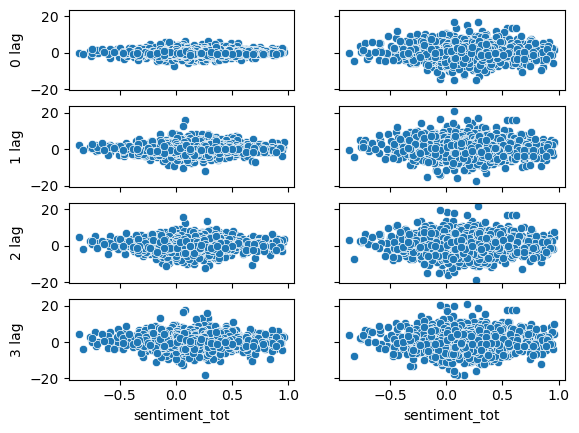

In [111]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
plt.sca(ax[0][0])
for i in range(0, 8):
    plt.sca(ax[i%4][i//4])
    sns.scatterplot(x= df_final['sentiment_tot'], y = df_final[str(i)+' lag'])  

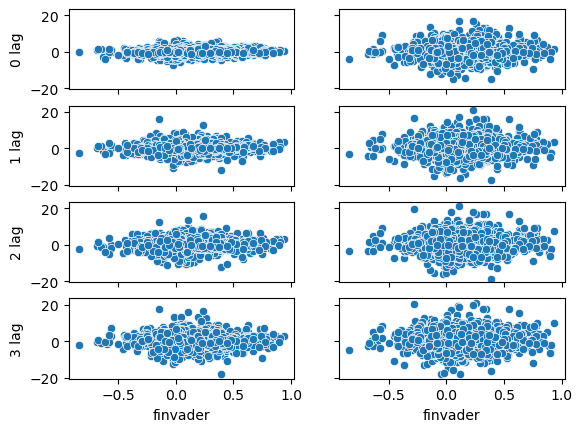

In [112]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
plt.sca(ax[0][0])
for i in range(0, 8):
    plt.sca(ax[i%4][i//4])
    sns.scatterplot(x= df_final['finvader'], y = df_final[str(i)+' lag'])  

In [113]:
correlators = []
for i in range(0, 8):
    correlators.append(df_all[['finvader', str(i) + ' lag']].corr(method = 'pearson'))
correlators

[          finvader     0 lag
 finvader  1.000000  0.079089
 0 lag     0.079089  1.000000,
           finvader     1 lag
 finvader  1.000000  0.051156
 1 lag     0.051156  1.000000,
           finvader     2 lag
 finvader  1.000000  0.042918
 2 lag     0.042918  1.000000,
           finvader     3 lag
 finvader  1.000000  0.010883
 3 lag     0.010883  1.000000,
           finvader     4 lag
 finvader  1.000000  0.034653
 4 lag     0.034653  1.000000,
           finvader     5 lag
 finvader  1.000000  0.043113
 5 lag     0.043113  1.000000,
           finvader     6 lag
 finvader  1.000000  0.038905
 6 lag     0.038905  1.000000,
           finvader     7 lag
 finvader  1.000000  0.041854
 7 lag     0.041854  1.000000]

In [114]:
correlators = []
for i in range(0, 8):
    correlators.append(df_all[['sentiment_tot', str(i) + ' lag']].corr(method = 'pearson'))
correlators

[               sentiment_tot     0 lag
 sentiment_tot       1.000000  0.026942
 0 lag               0.026942  1.000000,
                sentiment_tot     1 lag
 sentiment_tot       1.000000  0.022189
 1 lag               0.022189  1.000000,
                sentiment_tot     2 lag
 sentiment_tot       1.000000  0.000783
 2 lag               0.000783  1.000000,
                sentiment_tot     3 lag
 sentiment_tot       1.000000 -0.026964
 3 lag              -0.026964  1.000000,
                sentiment_tot     4 lag
 sentiment_tot       1.000000 -0.005395
 4 lag              -0.005395  1.000000,
                sentiment_tot    5 lag
 sentiment_tot        1.00000  0.01237
 5 lag                0.01237  1.00000,
                sentiment_tot     6 lag
 sentiment_tot       1.000000  0.019255
 6 lag               0.019255  1.000000,
                sentiment_tot     7 lag
 sentiment_tot       1.000000  0.014611
 7 lag               0.014611  1.000000]

In [ ]:
sns.histplot(df_all['sentiment_tot'])

# TODO

1. Sector Analysis

## Graphs with Complete CSV

This time instead of backfilling the missing stock prices for days when the market isn't open, we instead assign the articles to the next open market time. That is, articles published after the market is already closed, or on a day when the market is not open, will now have their sentiment scores averaged with the next open market date. 

This change more accurately reflects the trading patterns of those who read these articles. We will also try to construct graphs for all the different stocks, as well as the sectors, to see if there are certain stocks/sectors more influenced than others. 

In [123]:
df_all = pd.read_csv('../data/complete.csv')
df_all['Market Time'] = pd.to_datetime(df_all['Market Time'], utc = True)
df_all['Publishing Time'] = pd.to_datetime(df_all['Publishing Time'], utc = True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.info()
df_all.iloc[181]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69537 entries, 0 to 69536
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Publishing Time  63704 non-null  datetime64[ns, UTC]
 1   Market Time      69537 non-null  datetime64[ns, UTC]
 2   Date             69537 non-null  datetime64[ns]     
 3   Ticker           69537 non-null  object             
 4   Sector           69537 non-null  object             
 5   sentiment_neg    63704 non-null  float64            
 6   sentiment_neu    63704 non-null  float64            
 7   sentiment_pos    63704 non-null  float64            
 8   sentiment_tot    63704 non-null  float64            
 9   finvader         63704 non-null  float64            
 10  Headline         63704 non-null  object             
 11  Text             63704 non-null  object             
 12  URL              63704 non-null  object             
 13  Open            

Publishing Time                            2019-03-16 00:33:45+00:00
Market Time                                2019-03-18 20:00:00+00:00
Date                                             2019-03-18 00:00:00
Ticker                                                          AMZN
Sector                                                    Technology
sentiment_neg                                                    0.0
sentiment_neu                                                  0.769
sentiment_pos                                                  0.231
sentiment_tot                                                 0.7717
finvader                                                      0.6434
Headline           Amazon takes another step into the medical spa...
Text               Health experts say it's a smart move for Amazo...
URL                https://www.cnbc.com/2019/03/15/amazon-accepts...
Open                                                       85.635002
High                              

# Analysis by Ticker

In [126]:
tickers = df_all['Ticker'].unique()
# sectors = df_all['Sector'].unique()


(array(['AAPL', 'ABBV', 'AMZN', 'BAC', 'GOOGL', 'JNJ', 'JPM', 'LLY', 'MA',
        'MRK', 'MSFT', 'NVDA', 'UNH', 'V', 'WFC'], dtype=object),
 array(['Technology', 'Healthcare', 'Finance'], dtype=object))

In [164]:
ticker_frames = {}
df_t = df_all.groupby(['Date', 'Ticker'])[['sentiment_tot', 'finvader', 'Open', 'Close']].mean().reset_index()
for tick in tickers:
    ticker_frames[tick] = df_t[df_t['Ticker'] == tick].set_index('Date')
ticker_frames['AMZN'].loc['2019-03-18']

Ticker                AMZN
sentiment_tot      0.35028
finvader           0.49132
Open             85.635002
Close            87.107498
Name: 2019-03-18 00:00:00, dtype: object

In [152]:
#sanity check
open_market_days = ticker_frames['AMZN'].index.unique()
for tick in ticker_frames:
    check = ticker_frames[tick].index.unique()
    if (check != open_market_days).any():
        print('Error')
open_market_days

DatetimeIndex(['2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06',
               '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14',
               ...
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
               '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', name='Date', length=1279, freq=None)

In [161]:
def week_lag(df_input):
    timeframe = np.arange(0, 8, 1)
    for i in timeframe:
        df_lag = 100*(df_input.shift(periods = -i)['Close'][:len(df_stock)-i]-df_input['Open'][:len(df_stock)-i])/(df_input['Open'][:len(df_input)-i] ) 
        df_lag.rename(str(i) + " lag", inplace = True)
        df_input = pd.merge(df_input, df_lag, left_index = True, right_index = True, how = 'outer')
    return df_input

In [165]:
for tick in ticker_frames:
    ticker_frames[tick] = week_lag(ticker_frames[tick])


In [166]:
ticker_frames['AAPL'].loc['2019-03-15']

Ticker                AAPL
sentiment_tot     0.491367
finvader          0.293033
Open             44.428467
Close            44.733707
0 lag             0.687038
1 lag             1.714886
2 lag             0.908835
3 lag             1.790608
4 lag             5.539598
5 lag             3.354061
6 lag             2.104406
7 lag             1.049476
Name: 2019-03-15 00:00:00, dtype: object

In [168]:
for tick in ticker_frames:
    ticker_frames[tick] = ticker_frames[tick].dropna(subset = ['sentiment_tot', 'finvader'])

ticker_frames['AAPL'].tail()

,Ticker,sentiment_tot,finvader,Open,Close,0 lag,1 lag,2 lag,3 lag,4 lag,5 lag,6 lag,7 lag
Date,,,,,,,,,,,,,
2024-03-12,AAPL,0.075110,-0.057940,172.915453,172.995346,0.046204,-1.166607,-0.086621,-0.306085,0.329203,1.692179,3.187998,-1.028002
2024-03-13,AAPL,0.316991,0.163455,172.535987,170.898209,-0.949238,0.133122,-0.086824,0.549861,1.915835,3.414944,-0.810328,-0.283616
2024-03-14,AAPL,0.032337,0.098925,172.675796,172.765671,0.052048,-0.167720,0.468450,1.833317,3.331212,-0.890639,-0.364353,-1.191368
2024-03-15,AAPL,0.025845,-0.070636,170.938152,172.386185,0.847109,1.489746,2.868488,4.381609,0.116841,0.648477,-0.186945,-0.852951
2024-03-18,AAPL,-0.358300,-0.159367,175.332196,173.484695,-1.053714,0.290475,1.765676,-2.392212,-1.873900,-2.688385,-3.337700,-1.287245


In [171]:
for tick in ticker_frames:
    fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
    for i in range(0, 8):
        plt.sca(ax[i%4][i//4])
        sns.scatterplot(x= ticker_frames[tick]['sentiment_tot'], y = ticker_frames[tick][str(i)+' lag']) 
    plt.savefig(f'Figures/vanilla/{tick}_scatter_vanilla.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [172]:
for tick in ticker_frames:
    fig, ax = plt.subplots(nrows = 4, ncols = 2, sharex=True, sharey=True)
    for i in range(0, 8):
        plt.sca(ax[i%4][i//4])
        sns.scatterplot(x= ticker_frames[tick]['finvader'], y = ticker_frames[tick][str(i)+' lag']) 
    plt.savefig(f'Figures/finvader/{tick}_scatter_finvader.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [184]:
finvader_lag_corr = {}
for tick in ticker_frames:
    correlators = []
    for i in range(0, 8):
        correlators.append(ticker_frames[tick][['finvader', str(i) + ' lag']].corr(method = 'pearson').iloc[0,1])
    finvader_lag_corr[tick] = correlators

finvader_lag_corr

{'AAPL': [0.05968549621345936,
  0.03109161249557133,
  0.024311524627242675,
  -0.008822326309520862,
  0.01931858664949408,
  0.02627524047194808,
  0.019053830148516873,
  0.018701024462756486],
 'ABBV': [0.04565718239513709,
  0.060287961390058944,
  0.03386028080739061,
  0.016231452616142204,
  0.028277489834059297,
  0.016213878331611628,
  0.02253362235011386,
  0.019449280748269578],
 'AMZN': [-0.017959456232805742,
  -0.013190447170814242,
  -0.010726201903028613,
  -0.007339393002862388,
  -0.01387494316358872,
  -0.014480050634927563,
  -0.021665971790651373,
  -0.03091728728141633],
 'BAC': [0.07581448573594667,
  0.0559671459507414,
  0.0756597680455575,
  0.05029576149086759,
  0.041598492553662776,
  0.02512563987451336,
  0.0009101216432509419,
  0.00451088078870128],
 'GOOGL': [-0.015314452684228,
  0.0025560242198004613,
  0.020134354158179657,
  0.03427231167229134,
  0.02390535204434223,
  0.016635146793389934,
  0.021589077891385516,
  0.002003879762757657],
 'JNJ

In [187]:
vanilla_lag_corr = {}
for tick in ticker_frames:
    correlators = []
    for i in range(0, 8):
        correlators.append(ticker_frames[tick][['sentiment_tot', str(i) + ' lag']].corr(method = 'pearson').iloc[0,1])
    vanilla_lag_corr[tick] = correlators

vanilla_lag_corr

{'AAPL': [-0.0006774196847093656,
  0.009889708836968807,
  -0.008768097449367858,
  -0.022949742978427997,
  0.002680206340686654,
  0.02684351942537529,
  0.03486944819876054,
  0.02340425840118539],
 'ABBV': [0.020583754790177215,
  0.05914428086821558,
  0.016798199908013556,
  0.015280679301842928,
  0.032545987010035,
  0.016922007736862008,
  0.024999417977271097,
  0.017610651892694958],
 'AMZN': [-0.019050526062325795,
  -0.026598443487498347,
  -0.02874674119654455,
  -0.01793808813936082,
  -0.02215693862403025,
  -0.021773558871419674,
  -0.032865266846704745,
  -0.04275548302597377],
 'BAC': [0.047829310560593453,
  0.012957695414025716,
  0.03387034857630314,
  0.03228625233542182,
  0.01772266688688783,
  0.03358583288290514,
  0.017763034834125162,
  0.020734683654820944],
 'GOOGL': [-0.03000848416696215,
  -0.02134665086949496,
  0.011582097910175115,
  0.02191098724536189,
  0.006066496843205567,
  -0.0029313249901312915,
  0.00478389213573985,
  -0.014829700123843156

# Analysis by Sector

How do I measure the stock price of a sector? Weighed by Volume? 

In [188]:
sectors = df_all['Sector'].unique()

In [230]:
daily_volume = df_all.groupby(['Date','Sector', 'Ticker'])['Volume'].unique().astype(float)
daily_volume.loc['2019-03-15']


Sector      Ticker
Finance     BAC        82346200.0
            JPM        24811700.0
            MA          3894200.0
            V          20162000.0
            WFC        46117300.0
Healthcare  ABBV       12751100.0
            JNJ        11922500.0
            LLY        47331000.0
            MRK        17341046.0
            UNH         6466200.0
Technology  AAPL      156171600.0
            AMZN      151018000.0
            GOOGL      51886000.0
            MSFT       54681100.0
            NVDA       66148400.0
Name: Volume, dtype: float64

In [231]:
daily_volume = daily_volume.reset_index()
daily_total_volume = daily_volume.groupby(['Date', 'Sector'])['Volume'].sum().reset_index()
daily_total_volume
# daily_total_volume.loc['2019-03-15']


,Date,Sector,Volume
0,2019-03-01,Finance,88654400.0
1,2019-03-01,Healthcare,75045905.0
2,2019-03-01,Technology,296348800.0
3,2019-03-04,Finance,96013900.0
4,2019-03-04,Healthcare,90887855.0
...,...,...,...
3832,2024-03-27,Healthcare,34547500.0
3833,2024-03-27,Technology,191736800.0
3834,2024-03-28,Finance,73568700.0
3835,2024-03-28,Healthcare,28819300.0


In [233]:
daily_total_volume.rename(columns ={'Volume':'Total Volume'}, inplace = True)
daily_total_volume.head()

,Date,Sector,Total Volume
0,2019-03-01,Finance,88654400.0
1,2019-03-01,Healthcare,75045905.0
2,2019-03-01,Technology,296348800.0
3,2019-03-04,Finance,96013900.0
4,2019-03-04,Healthcare,90887855.0


In [235]:
inter = pd.merge(daily_volume, daily_total_volume, on = ['Date', 'Sector'])
inter['percent volume'] = inter['Volume']/inter['Total Volume']
inter

,Date,Sector,Ticker,Volume,Total Volume,percent volume
0,2019-03-01,Finance,BAC,45771500.0,88654400.0,0.516291
1,2019-03-01,Finance,JPM,13813300.0,88654400.0,0.155811
2,2019-03-01,Finance,MA,3001400.0,88654400.0,0.033855
3,2019-03-01,Finance,V,7016800.0,88654400.0,0.079148
4,2019-03-01,Finance,WFC,19051400.0,88654400.0,0.214895
...,...,...,...,...,...,...
19180,2024-03-28,Technology,AAPL,65672700.0,193602100.0,0.339215
19181,2024-03-28,Technology,AMZN,38051600.0,193602100.0,0.196545
19182,2024-03-28,Technology,GOOGL,24485400.0,193602100.0,0.126473
19183,2024-03-28,Technology,MSFT,21871200.0,193602100.0,0.112970


In [145]:
sector_frames = {}
df_s = df_all.groupby(['Date', 'Sector'])[['sentiment_tot','finvader']].mean().reset_index()
for sect in sectors:
    sector_frames[sect] = df_s[df_s['Sector'] == sect].set_index('Date')
sector_frames['Technology'].loc['2019-03-18']

Sector           Technology
sentiment_tot      0.353785
finvader           0.378762
Name: 2019-03-18 00:00:00, dtype: object

In [242]:
x = df_all[df_all['Ticker'] == 'AAPL']
x[x['URL'].isna()]


,Publishing Time,Market Time,Date,Ticker,Sector,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_tot,finvader,Headline,Text,URL,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,NaT,2019-03-01 21:00:00+00:00,2019-03-01,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.887973,42.097075,41.553888,42.053814,103544800,0.0,0.0
15,NaT,2019-03-04 21:00:00+00:00,2019-03-04,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.226871,42.721989,41.813471,42.265327,109744800,0.0,0.0
30,NaT,2019-03-05 21:00:00+00:00,2019-03-05,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.286956,42.301376,41.950465,42.188412,78949600,0.0,0.0
45,NaT,2019-03-06 21:00:00+00:00,2019-03-06,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.981718,42.178806,41.806265,41.945667,83241600,0.0,0.0
60,NaT,2019-03-07 21:00:00+00:00,2019-03-07,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.789428,41.926429,41.344785,41.460152,99185600,0.0,0.0
75,NaT,2019-03-08 21:00:00+00:00,2019-03-08,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.936194,41.597153,40.739107,41.558697,95997600,0.0,0.0
90,NaT,2019-03-11 20:00:00+00:00,2019-03-11,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.178804,43.051267,42.145155,42.998390,128044000,0.0,0.0
105,NaT,2019-03-12 20:00:00+00:00,2019-03-12,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.262769,43.904500,43.111348,43.481487,129870400,0.0,0.0
120,NaT,2019-03-13 20:00:00+00:00,2019-03-13,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.803550,44.055917,43.483886,43.673763,124130000,0.0,0.0
135,NaT,2019-03-14 20:00:00+00:00,2019-03-14,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.200130,44.248203,43.878064,44.159271,94318000,0.0,0.0
